# CellFIT Solver
XJ

In [1]:
import numpy as np
import os, sys
import math
import pylab as pl
import matplotlib.pyplot as plt
import csv
import scipy.stats as st
from numpy import linalg
from scipy.sparse.linalg import lsqr
from matplotlib import collections as mc
from matplotlib.pyplot import figure
from numpy import where

def blockPrint():
    sys.stdout = open(os.devnull, 'w')
    
def enablePrint():
    sys.stdout = sys.__stdout__

##########################################
# DIRECTORIES
# Enter directory of the .txt file containing FEM data
##########################################
dir = '/Users/xj/Desktop/PHYS_4998/Mesh002/Outline_0_000.txt'
#dir = '/Users/xj/Desktop/PHYS_4998/hex_test_images/nearseg_hex150/CellFIT_MeshOfHexagonalCells150.txt'
dir_cellfit = '/Users/xj/Desktop/PHYS_4998/Mesh002/Outline_0_000_Output_exclude_outside_edges.csv'
#dir_cellfit = '/Users/xj/Desktop/PHYS_4998/hex_test_images/nearseg_hex90/CellFIT_MeshOfHexagonalCells090_Output.csv'

##########################################
# DEFINE LISTS
##########################################
N_TJ = 0    # Number of triple junctions
N_Ten = 0 # Number of tensions
ID_TJ = [] # Indices of nodes that are triple junctions
ID_TJ_Edges = [] # Indices of edges that are associated with triple junctions
X,Y = [],[] # list of x, y position coordinates
MAP_Edge_to_Ten = [] # edges and their associated tension (two edges have the same tension)
#LIST_rho = [] # list of the radius of curvatures
Unique = []   # number of unique edges involved in the calculation
vect_lst = [] # 6 by N_TJ list of direction vectors 
                # vect_lst indexing:
                # (0,1) -> Vec1 (x,y) 
                # (2,3) -> Vec2 (x,y)
                # (4,5) -> Vec3 (x,y)
edge_nodes = [] # [edge ind, node1, node2] Indices of nodes associated with each edge, for all edges
all_nodes = []  # [Node index, x coordinate, y coordinate, edge1, edge2] for all nodes
graph = []      # for plotting with line collection e.g. [[(0, 0), (1, 1)], [(2, 3), (3, 3)]]
unique_edges_nodes = [] # [edge ind, node1, node2] Indices of nodes associated with each edge, for edges of concern


##########################################
#
# PARSE INFORMATION
#
##########################################


print('PARSING FILE %s...'%dir)

# Parse .txt file and fill above lists
with open(dir, 'r') as df:
    for line in df:
        # Select triple junctions by using 'Vec1' as filter
        if 'Vec1' in line:
            
            # Break each line into elements
            elements = line.split('\t')
            
            # elements[0]: node number
            ID_TJ.append(int(elements[0]))
            
            # elements[1:2]: x, y coordinates of the triple junction
            X.append(int(elements[1]))
            Y.append(int(elements[2]))
            
            # elements[3:4] are repeats of elements[1:2]
            
            # elements[5:7]: vectors representing the 3 edges e.g. (Vec1 r*cos(theta) r*sin(theta))
            vect_lst.append([float(elements[5].split(' ')[1]), float(elements[5].split(' ')[2]),
                            float(elements[6].split(' ')[1]), float(elements[6].split(' ')[2]),
                            float(elements[7].split(' ')[1]), float(elements[7].split(' ')[2])]) 
            
            # elements[8]: 'Edge'
            
            # elements[9:11]: edge numbers of the 3 associated edges
            ID_TJ_Edges.append(int(elements[9]))
            ID_TJ_Edges.append(int(elements[10]))
            ID_TJ_Edges.append(int(elements[11]))
            
            # count the triple junction
            N_TJ +=1

print('---Shared edges---')
for j in ID_TJ_Edges:
    if j not in Unique:
        Unique.append(j)
    else:
        print(j)

with open(dir, 'r') as df:
    for line in df:
        if 'Edge2D' in line:
            elements = line.split('\t')
            edge_nodes.append([int(elements[0]), int(elements[2]), int(elements[3])])
            if int(elements[0]) in Unique:
                unique_edges_nodes.append([int(elements[0]), int(elements[2]), int(elements[3])])
        # Read in radius of curvatures
#         if 'Circle' in line:
#             elements = line.split('\t')
#             LIST_rho.append()

with open(dir, 'r') as df:
    flag = False
    for line in df:
        if 'BEGIN_NODES' in line:
            flag = True
            continue
        if 'BEGIN_ALLEDGES' in line:
            break
        if flag == True:
            elements = line.split('\t')
            try:
                all_nodes.append([int(elements[0]),
                                  float(elements[1]),
                                  float(elements[2]),
                                  int(elements[-4]),
                                  int(elements[-3])
                                 ])
            except:
                continue


ind_node = np.array(all_nodes)[:,0]
# change unique_edges_nodes to edge_nodes TO VISUALIZE ALL EDGES
for i in range(len(unique_edges_nodes)): 
    ind0 = where(ind_node == unique_edges_nodes[i][1])[0][0]
    ind1 = where(ind_node == unique_edges_nodes[i][2])[0][0]
    graph.append([(all_nodes[ind0][1], all_nodes[ind0][2]),
                  (all_nodes[ind1][1], all_nodes[ind1][2])])
    # if i == 4: print(all_nodes[ind0][0], all_nodes[ind1][0])

# Convert to numpy array for easy handling
unique_edges_nodes = np.array(unique_edges_nodes)
edge_nodes = np.array(edge_nodes)
all_nodes = np.array(all_nodes)

print('DONE...')

##########################################
#
# Creating a map of 
# edge numbers -> tension number
#
##########################################

print('CREATING MAP OF EDGE# -> TENSION# ...')
# Infinite while loop occurs when an input edge points out of bounds
# Can be solved in 3 ways
# 1) set a max iteration of while loop (depending on number of intermediate nodes created);
#    switching to a for loop induces the same effect
# 2) add in information about the 3rd edge for all_nodes, if a third edge is found then
#    we've exited the boundary and we should break the loop
MAP_Edge_to_Ten = []
N_Ten = 0

#blockPrint()
prog = 1
for edge_ind1 in ID_TJ_Edges:
    # Print progress
    if prog % int(len(ID_TJ_Edges)/5) == 0: print(math.ceil(100*prog/len(ID_TJ_Edges)),'% DONE')
    prog += 1
    
    tj1 = False
    tj2 = False
    # matched = False
    edge_ind2 = edge_ind1
    node1 = unique_edges_nodes[where(edge_ind1 == unique_edges_nodes[:,0])[0][0], 1]
    node2 = unique_edges_nodes[where(edge_ind1 == unique_edges_nodes[:,0])[0][0], 2]
    
    # check for existence in MAP_Edge_to_Ten to avoid double counting
    if edge_ind1 in [item[0] for item in MAP_Edge_to_Ten]: continue
    
    #while matched == False:
    for itr in range(10):
    
#         print('---------')
#         print('edge input: %d'%edge_ind1)
#         print('potential edge pair:', edge_ind1, edge_ind2)
#         print('nodes: %d %d'%(node1,node2))
        
        if node1 in ID_TJ:
            tj1 = True
            #print('node1 %d is a tj'%node1)
        else: # find the edge connects to the other tj
            #print('node1 %d is not a tj'%node1)
            newedge1 = all_nodes[where(node1 == all_nodes[:,0])[0][0], -2]
            newedge2 = all_nodes[where(node1 == all_nodes[:,0])[0][0], -1]
            #print('new edge options:', newedge1, newedge2)
            if newedge1 != edge_ind2:
                edge_ind2 = newedge1
                newnode1 = edge_nodes[where(edge_ind2 == edge_nodes[:,0])[0][0], 1]
                newnode2 = edge_nodes[where(edge_ind2 == edge_nodes[:,0])[0][0], 2]
                if newnode1 != node1:
                    node1 = newnode1
                else:
                    node1 = newnode2
            else:
                edge_ind2 = newedge2
                newnode1 = edge_nodes[where(edge_ind2 == edge_nodes[:,0])[0][0], 1]
                newnode2 = edge_nodes[where(edge_ind2 == edge_nodes[:,0])[0][0], 2]
                if newnode1 != node1:
                    node1 = newnode1
                else:
                    node1 = newnode2
#             print('new edge chosen:', edge_ind2)
#             print('new node options:', newnode1, newnode2)
#             print('new node chosen:', node1)
        
        if node2 in ID_TJ:
            tj2 = True
            #print('node2 %d is a tj'%node2)
        else: # find the edge connects to the other tj
            #print('node2 %d is not a tj'%node2)
            newedge1 = all_nodes[where(node2 == all_nodes[:,0])[0][0], -2]
            newedge2 = all_nodes[where(node2 == all_nodes[:,0])[0][0], -1]
            #print('new edge options:', newedge1, newedge2)
            if newedge1 != edge_ind2:
                edge_ind2 = newedge1
                newnode1 = edge_nodes[where(edge_ind2 == edge_nodes[:,0])[0][0], 1]
                newnode2 = edge_nodes[where(edge_ind2 == edge_nodes[:,0])[0][0], 2]
                if newnode1 != node2:
                    node2 = newnode1
                else:
                    node2 = newnode2
            else:
                edge_ind2 = newedge2
                newnode1 = edge_nodes[where(edge_ind2 == edge_nodes[:,0])[0][0], 1]
                newnode2 = edge_nodes[where(edge_ind2 == edge_nodes[:,0])[0][0], 2]
                if newnode1 != node2:
                    node2 = newnode1
                else:
                    node2 = newnode2
#             print('new edge chosen:', edge_ind2)
#             print('new node options:', newnode1, newnode2)
#             print('new node chosen:', node2)
        
        if tj1 and tj2:
            # record the two edge inds and map them to the same tension ind
            MAP_Edge_to_Ten.append([edge_ind1, N_Ten])
            MAP_Edge_to_Ten.append([edge_ind2, N_Ten])
#             print('gottem')
#             print('the associated edges are: %d and %d'%(edge_ind1, edge_ind2))
#             print('the associated nodes are: %d and %d'%(node1, node2))
            break
            # matched = True
    else: # search is out of bounds - edge pointing away from region of interest
        MAP_Edge_to_Ten.append([edge_ind1, N_Ten])
        
    # count tensions
    N_Ten += 1

MAP_Edge_to_Ten = np.array(MAP_Edge_to_Ten, dtype=int)
print('DONE...')
print('Number of tensions = ', N_Ten)
print('Number of triple junctions =', N_TJ)

##########################################
#
# VISUALIZATION OF SETUP
#
##########################################

c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])
lc = mc.LineCollection(graph, colors=c, linewidths=2)
fig, ax = pl.subplots(figsize=(10,10))
ax.add_collection(lc)
plt.title(dir)
plt.grid()
ax.margins(0.1)
#plt.scatter(X, Y, marker='o', color='black')
# plt.plot(387, -46, marker='o')
# plt.plot(397, -44, marker='o')
# plt.plot(378, -49, marker='o')
# plt.plot(378, -59, marker='o')
# plt.plot(378, -69, marker='o')
plt.show()
# plt.savefig('mesh002_tj_only_visualization')


##########################################
#
# Matrix construction and solve system of equations
#
##########################################

def writetofile(filename, results):
    """
    filename: string
    results: array
    Prints results to txt file with the given name.
    Dependencies: global variable MAP_Edge_to_Ten
    """
    f = open(filename, 'w')
    f.write('Tension                 Associated edges\n')
    for i in range(len(results)):
        ass_edges = where(i == MAP_Edge_to_Ten[:,1])[0]
        f.write(str(results[i])+'\t'+str(ass_edges)+'\n')
    f.close()

def MAP_Edge_to_Tension(Edge_ID):
    """
    Takes in an edge ID and returns the tension ID
    """
    global MAP_Edge_to_Ten
    ind = where(Edge_ID == MAP_Edge_to_Ten[:,0])[0][0]
    return MAP_Edge_to_Ten[ind, 1]
    
G = np.mat(np.zeros((N_Ten, 2*N_TJ)))
A = np.zeros((N_Ten+1, N_Ten+1))
b = np.zeros(N_Ten+1)
A[:-1,-1] = 1
A[-1,:-1] = 1
b[-1] = N_Ten

# go through all triple junctions
for i in range(N_TJ):
    # go through the 3 edges of each triple junction
    for vec in range(3):
        
        # norm of the vector representing an edge
        norm = np.sqrt(vect_lst[i][2*vec]**2 + vect_lst[i][2*vec + 1]**2)
        
        # column number that correspond to the particular tension
        col = MAP_Edge_to_Tension(ID_TJ_Edges[3*i + vec])
    
        # assign values to matrix
        #if i == 0: print(vec, vect_lst[i][2*vec + 1] / norm)
        G[col, 2*i] = vect_lst[i][2*vec] / norm
        G[col, 2*i + 1] = vect_lst[i][2*vec + 1] / norm

# Due to confusing numpy indices, the row and columns have been
# swapped - thus G.T * G in the formalism is computed as G * G.T
C = np.matmul(G, G.T)
C = 2.0*C # interestingly, having this factor of 2 does not change the results
A[:-1,:-1] = C
# print('---G matrix---')
# print(G.shape, G)
# print('---G.T matrix---')
# print(G.T.shape, G.T)
# print('---G.T * G matrix---')
# print(C.shape, C)
# print('---A matrix---')
# print(A.shape, A)

print('---Gamma---')
# print('linalg.lstsq')
# gamma = linalg.lstsq(A, b, rcond=None)
# print(gamma[0])
print('linalg.solve')
gamma2 = linalg.solve(A, b)
print('Max tension = %f\nMin tension = %f'%(max(gamma2), min(gamma2)))
#writetofile('mesh002_tensions.txt', gamma2)


##########################################
#
# VISUALIZATION OF TENSIONS
#
##########################################

lc = mc.LineCollection(graph, array=gamma2[:-1], cmap=plt.cm.jet, linewidths=3)
fig, ax = pl.subplots(figsize=(10,10))
ax.add_collection(lc)
plt.title(dir)
plt.grid()
ax.margins(0.1)
plt.scatter(X, Y, s=15, marker='o', color='black')
#plt.show()
#plt.savefig('mesh002_tension_solved.png')

jetc = np.zeros((100,1))
for i in range(100):
    jetc[i,0] = i
fig = plt.figure(figsize=(25/3, 6.25))
# show color bar
# ax = fig.add_subplot(111)
# ax.set_axis_off()
# im = ax.imshow(jetc, cmap=plt.cm.jet)

##########################################
#
# Read in CellFIT tension results
#
##########################################

gamma_c = np.zeros(N_Ten)
gamma_c_inc = np.zeros(N_Ten+50)
CellFIT_results_EdgeID = np.zeros(N_Ten, dtype=int)
with open(dir_cellfit, mode='r') as csvf:
    allresults = csv.reader(csvf, delimiter=' ')
    i = -1
    for row in allresults:
        row = row[0].split(',')
        if i >= 0:
            CellFIT_results_EdgeID[i] = int(row[0])
            gamma_c[i] = float(row[1])
        i += 1  


##########################################
#
# COMPARE RESULTS
#
##########################################

gamma_p = gamma2.copy()[:-1]
print(len(gamma_p))
print('----------CellFIT results excl edges------------')
#mean, var, std = st.mvsdist(gamma_c)
print('Mean =', gamma_c.mean())
print('Interval: [%f, %f]'%(gamma_c.min(),gamma_c.max()))
print('Std =', gamma_c.std())
figure(2)
plt.hist(gamma_c, bins=30, density=True)
plt.title('CellFIT results')

print('----------Python results------------')
print('Mean =', gamma_p.mean())
print('Interval: [%f, %f]'%(gamma_p.min(),gamma_p.max()))
print('Std =', gamma_p.std())
figure(3)
fig = plt.figure(figsize=(25/3, 6.25))
plt.hist(gamma_p, bins=30, density=True)
plt.title('Python results')

PARSING FILE /Users/xj/Desktop/PHYS_4998/Mesh002/Outline_0_000.txt...
---Shared edges---
346
347
348
354
DONE...
CREATING MAP OF EDGE# -> TENSION# ...
20 % DONE
40 % DONE
60 % DONE
80 % DONE
100 % DONE
DONE...
Number of tensions =  349
Number of triple junctions = 219


---Gamma---
linalg.solve
Max tension = 5.504199
Min tension = -0.028829
349
----------CellFIT results excl edges------------
Mean = 1.0000000028653295
Interval: [0.242492, 5.504199]
Std = 0.6727014321818996
----------Python results------------
Mean = 1.0000000000000004
Interval: [0.242492, 5.504199]
Std = 0.6727014244619424


Text(0.5,1,'Python results')

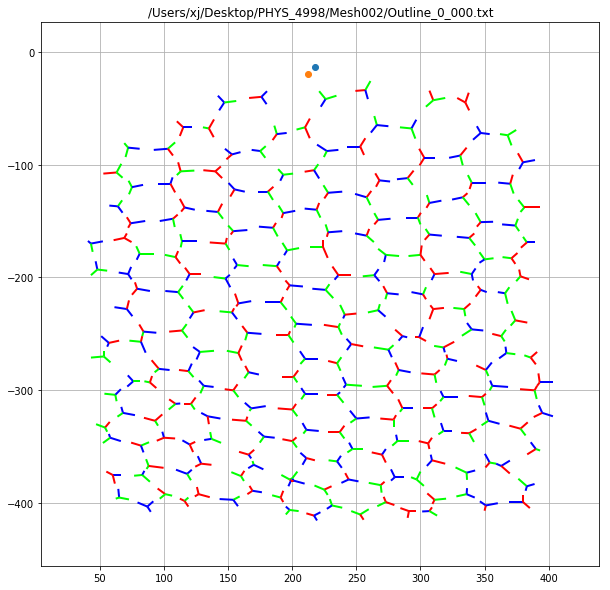

In [2]:
c = np.array([(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])
lc = mc.LineCollection(graph, colors=c, linewidths=2)
fig, ax = pl.subplots(figsize=(10,10))
ax.add_collection(lc)
plt.title(dir)
plt.grid()
ax.margins(0.1)
#plt.scatter(X, Y, marker='o', color='black')
# plt.plot(387, -46, marker='o')
# plt.plot(397, -44, marker='o')
# plt.plot(378, -49, marker='o')
# plt.plot(378, -59, marker='o')
# plt.plot(378, -69, marker='o')

# plt.plot(72, -85, marker='o')
# plt.plot(63, -107, marker='o')
# plt.plot(291, -407, marker='o')

plt.plot(218, -14, marker='o')
plt.plot(212, -20, marker='o')
plt.show()
# plt.savefig('mesh002_tj_only_visualization')

## Calculate pressures

### Find associated cells, radii, center points

In [3]:
LIST_Edge_Node = [] # [[Edge_ID, Node_1, Node_2], [], ...] 
                    # Nodes listed counter-clockwise
LIST_Edge_Cell = [] # [[Edge_ID, Cell_1_ID, Cell_2_ID], [], ...]
LIST_rho = [] # list of radius of curvatures
LIST_p0 = [] # list of coordinates of circle centers [[x,y], [], ...]
with open(dir, 'r') as df:
    flag = False
    for line in df:
        if 'BEGIN_EDGEGROUPS' in line:
            flag = True
            continue
        if 'BEGIN_ALLFACES' in line:
            break
        if flag:
            elements = line.split('\t')
            #print(elements)
            try:
                if float(elements[0]) in CellFIT_results_EdgeID and 'Circle' in elements[4]:
                    LIST_Edge_Node.append([int(elements[0]), 
                                           int(elements[1].split(' ')[0]),
                                           int(elements[1].split(' ')[1])])
                    LIST_Edge_Cell.append([int(elements[0]), 
                                           int(elements[2].split(' ')[0]),
                                           int(elements[2].split(' ')[1])])
                    LIST_rho.append(float(elements[4].split(' ')[1]))
                    LIST_p0.append([float(elements[4].split(' ')[2]),
                                    float(elements[4].split(' ')[3])])
                if float(elements[0]) in CellFIT_results_EdgeID and 'Line' in elements[4]:
                    LIST_Edge_Node.append([int(elements[0]), 
                                           int(elements[1].split(' ')[0]),
                                           int(elements[1].split(' ')[1])])
                    LIST_Edge_Cell.append([int(elements[0]), 
                                           int(elements[2].split(' ')[0]),
                                           int(elements[2].split(' ')[1])])
                    LIST_rho.append(-1) # -1 for cell-cell boundaries that are lines
                    LIST_p0.append([-1,-1])
                    
            except:
                continue

LIST_rho = np.array(LIST_rho)

print('edges', len(LIST_Edge_Cell))
print('radii', len(LIST_rho))
print('centers', len(LIST_p0))
#print(len(LIST_rho), LIST_rho)

# # tension/rho
# q = gamma_c/LIST_rho
# print(len(q), q)

# # Solve the pressures
# p = linalg.solve(Gp, q)
# print(p)

edges 349
radii 349
centers 349


### Calculate cross products

In [7]:
LIST_Edge_Node

[[8, 2, 11],
 [9, 3, 12],
 [11, 1, 13],
 [12, 6, 14],
 [14, 4, 15],
 [17, 5, 17],
 [19, 11, 13],
 [20, 11, 19],
 [21, 13, 20],
 [22, 14, 17],
 [23, 14, 21],
 [24, 17, 22],
 [25, 12, 15],
 [26, 12, 23],
 [27, 15, 24],
 [30, 18, 26],
 [33, 16, 28],
 [34, 19, 23],
 [35, 19, 29],
 [36, 23, 30],
 [37, 22, 26],
 [38, 22, 31],
 [39, 26, 32],
 [40, 20, 21],
 [41, 20, 33],
 [42, 21, 34],
 [43, 24, 28],
 [44, 24, 35],
 [45, 28, 36],
 [47, 25, 38],
 [48, 29, 33],
 [49, 29, 39],
 [50, 33, 40],
 [51, 32, 38],
 [52, 32, 41],
 [53, 38, 42],
 [54, 31, 34],
 [55, 31, 43],
 [56, 34, 44],
 [57, 30, 35],
 [58, 30, 45],
 [59, 35, 46],
 [61, 27, 36],
 [62, 36, 48],
 [63, 41, 43],
 [64, 41, 49],
 [65, 43, 50],
 [66, 40, 44],
 [67, 40, 51],
 [68, 44, 52],
 [70, 37, 42],
 [71, 42, 54],
 [72, 39, 45],
 [73, 39, 55],
 [74, 45, 56],
 [75, 46, 48],
 [76, 46, 57],
 [77, 48, 58],
 [78, 49, 54],
 [79, 49, 59],
 [80, 54, 60],
 [81, 50, 52],
 [82, 50, 61],
 [83, 52, 62],
 [84, 51, 55],
 [85, 51, 63],
 [86, 55, 64],
 [8

In [8]:
LIST_Edge_Cell

[[8, 2, 7],
 [9, 3, 7],
 [11, 2, 8],
 [12, 4, 8],
 [14, 3, 9],
 [17, 4, 10],
 [19, 2, 11],
 [20, 7, 11],
 [21, 8, 11],
 [22, 4, 12],
 [23, 8, 12],
 [24, 10, 12],
 [25, 3, 13],
 [26, 7, 13],
 [27, 9, 13],
 [30, 10, 14],
 [33, 9, 15],
 [34, 7, 16],
 [35, 11, 16],
 [36, 13, 16],
 [37, 10, 17],
 [38, 12, 17],
 [39, 14, 17],
 [40, 8, 18],
 [41, 11, 18],
 [42, 12, 18],
 [43, 9, 19],
 [44, 13, 19],
 [45, 15, 19],
 [47, 14, 20],
 [48, 11, 21],
 [49, 16, 21],
 [50, 18, 21],
 [51, 14, 22],
 [52, 17, 22],
 [53, 20, 22],
 [54, 12, 23],
 [55, 17, 23],
 [56, 18, 23],
 [57, 13, 24],
 [58, 16, 24],
 [59, 19, 24],
 [61, 15, 25],
 [62, 19, 25],
 [63, 17, 26],
 [64, 22, 26],
 [65, 23, 26],
 [66, 18, 27],
 [67, 21, 27],
 [68, 23, 27],
 [70, 20, 28],
 [71, 22, 28],
 [72, 16, 29],
 [73, 21, 29],
 [74, 24, 29],
 [75, 19, 30],
 [76, 24, 30],
 [77, 25, 30],
 [78, 22, 31],
 [79, 26, 31],
 [80, 28, 31],
 [81, 23, 32],
 [82, 26, 32],
 [83, 27, 32],
 [84, 21, 33],
 [85, 27, 33],
 [86, 29, 33],
 [87, 24, 34],
 [88,

In [9]:
LIST_Cell_Node

array([list([2, 2, 267, 268, 269, 270, 271, 272, 273, 1, 318, 319, 13, 335, 336, 337, 11, 311, 312]),
       list([3, 4, 274, 275, 276, 277, 278, 279, 280, 3, 313, 314, 315, 12, 351, 352, 15, 324, 325]),
       list([4, 6, 281, 282, 283, 284, 285, 286, 287, 5, 331, 332, 17, 344, 345, 14, 320, 321]),
       list([5, 8, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 7, 326, 327, 328, 16, 369, 370]),
       list([6, 10, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 9, 361, 362, 18, 333, 334]),
       list([7, 314, 313, 3, 3, 309, 310, 312, 311, 11, 11, 338, 339, 340, 19, 373, 374, 23, 353, 354, 355, 315]),
       list([8, 318, 1, 1, 316, 317, 321, 320, 14, 14, 346, 347, 348, 21, 386, 387, 20, 341, 342, 343, 319]),
       list([9, 327, 326, 7, 7, 322, 323, 325, 324, 15, 15, 356, 357, 358, 24, 392, 393, 28, 371, 372, 328]),
       list([10, 331, 5, 5, 329, 330, 334, 333, 18, 18, 363, 364, 26, 379, 380, 22, 349, 350, 332]),
       list([11, 336, 335, 13, 343, 342, 341, 20, 20, 38

In [4]:
LIST_v1 = np.zeros((2,N_Ten)) # vector p0 to p1
LIST_v2 = np.zeros((2,N_Ten)) # vector p0 to p2
LIST_crossp = np.zeros(N_Ten) # 1 denotes counter-clockwise
                              # -1 denotes clockwise

for i in range(N_Ten):
    try:
        p1_ind = where(LIST_Edge_Node[i][1] == all_nodes[:,0])[0][0] # node index of p1
        p2_ind = where(LIST_Edge_Node[i][2] == all_nodes[:,0])[0][0] # node index of p2
    except:
        print("ERROR", 'Node_IDs', LIST_Edge_Node[i][1], LIST_Edge_Node[i][2])
        continue
    p0x, p0y = LIST_p0[i][0], LIST_p0[i][1]
    LIST_v1[0, i], LIST_v1[1, i] = all_nodes[p1_ind, 1] - p0x, all_nodes[p1_ind, 2] - p0y
    LIST_v2[0, i], LIST_v2[1, i] = all_nodes[p2_ind, 1] - p0x, all_nodes[p2_ind, 2] - p0y
    LIST_crossp[i] = LIST_v1[0, i] * LIST_v2[1, i] - LIST_v1[1, i] * LIST_v2[0, i]
    
    print('p0', p0x, p0y)
    print('p1', all_nodes[p1_ind, 1], all_nodes[p1_ind, 2])
    print('p2', all_nodes[p2_ind, 1], all_nodes[p2_ind, 2])
    print(np.sign(LIST_crossp[i]))
    

p0 300.968761187063 -57.7081080133743
p1 274.0 -15.0
p2 257.0 -34.0
1.0
p0 226.543950691706 -67.0242892618979
p1 296.0 -15.0
p2 310.0 -43.0
-1.0
p0 302.61091489562 22.8160092995435
p1 212.0 -20.0
p2 226.0 -42.0
1.0
p0 -1 -1
p1 188.0 -27.0
p2 176.0 -40.0
-1.0
p0 365.954369429091 -50.0216810446467
p1 347.0 -25.0
p2 335.0 -45.0
1.0
p0 228.20186950532 40.9880688381143
p1 131.0 -26.0
p2 147.0 -45.0
1.0
p0 259.858869654115 -107.279274869303
p1 257.0 -34.0
p2 226.0 -42.0
1.0
p0 -1 -1
p1 257.0 -34.0
p2 266.0 -65.0
-1.0
p0 -1 -1
p1 226.0 -42.0
p2 210.0 -67.0
-1.0
p0 -1 -1
p1 176.0 -40.0
p2 147.0 -45.0
-1.0
p0 -1 -1
p1 176.0 -40.0
p2 188.0 -73.0
-1.0
p0 418.470921396959 -200.570649347065
p1 147.0 -45.0
p2 135.0 -68.0
1.0
p0 321.229186992704 -64.7116998773624
p1 310.0 -43.0
p2 335.0 -45.0
-1.0
p0 360.923869868997 -95.5626740338189
p1 310.0 -43.0
p2 293.0 -68.0
1.0
p0 727.006084969233 111.66559343215
p1 335.0 -45.0
p2 347.0 -72.0
1.0
p0 182.851669848287 3.36474738117671
p1 101.0 -50.0
p2 115.0 -67

p1 111.0 -213.0
p2 123.0 -231.0
1.0
p0 362.718932775949 -164.487557588296
p1 347.0 -211.0
p2 366.0 -214.0
1.0
p0 291.968867004673 -182.909645635067
p1 347.0 -211.0
p2 334.0 -228.0
-1.0
p0 447.247598111882 -199.506639783043
p1 366.0 -214.0
p2 374.0 -238.0
1.0
p0 -1 -1
p1 302.0 -215.0
p2 274.0 -214.0
-1.0
p0 383.833062071915 -173.566487810699
p1 302.0 -215.0
p2 310.0 -228.0
1.0
p0 -1 -1
p1 274.0 -214.0
p2 267.0 -229.0
-1.0
p0 176.145258540593 -317.123155464509
p1 158.0 -223.0
p2 191.0 -222.0
-1.0
p0 177.114911761012 -240.920104612601
p1 158.0 -223.0
p2 153.0 -231.0
1.0
p0 -1 -1
p1 191.0 -222.0
p2 203.0 -241.0
-1.0
p0 50.9157232076357 -321.348450327357
p1 45.0 -226.0
p2 71.0 -228.0
-1.0
p0 -8.43630956434491 -294.700261341208
p1 71.0 -228.0
p2 84.0 -248.0
-1.0
p0 322.000000000139 -292.777777824676
p1 334.0 -228.0
p2 310.0 -228.0
1.0
p0 364.18638552858 -228.235080428335
p1 334.0 -228.0
p2 340.0 -246.0
1.0
p0 -1 -1
p1 310.0 -228.0
p2 299.0 -253.0
-1.0
p0 137.21791013805 -293.155887258281
p1 

p1 354.0 -364.0
p2 363.0 -367.0
-1.0
p0 334.846870263561 -346.654316328842
p1 354.0 -364.0
p2 336.0 -373.0
-1.0
p0 -1 -1
p1 363.0 -367.0
p2 383.0 -385.0
1.0
p0 221.417055826207 -382.564681472073
p1 336.0 -373.0
p2 336.0 -392.0
-1.0
p0 -1 -1
p1 45.0 -366.0
p2 60.0 -375.0
1.0
p0 -1 -1
p1 170.0 -366.0
p2 198.0 -379.0
1.0
p0 178.380799101081 -384.618983658771
p1 170.0 -366.0
p2 160.0 -376.0
1.0
p0 -1 -1
p1 160.0 -376.0
p2 169.0 -389.0
1.0
p0 107.030820518392 -384.866376117573
p1 88.0 -367.0
p2 83.0 -375.0
1.0
p0 85.6201928972187 -447.356650241419
p1 88.0 -367.0
p2 118.0 -374.0
-1.0
p0 83.8279173326023 -403.561027351099
p1 118.0 -374.0
p2 127.0 -392.0
-1.0
p0 -1 -1
p1 60.0 -375.0
p2 83.0 -375.0
1.0
p0 5.17758723862806 -400.374705725544
p1 60.0 -375.0
p2 65.0 -395.0
-1.0
p0 180.619456897758 -290.255379547479
p1 83.0 -375.0
p2 101.0 -392.0
1.0
p0 285.501456728619 -407.343279788769
p1 280.0 -377.0
p2 297.0 -379.0
-1.0
p0 -1 -1
p1 280.0 -377.0
p2 269.0 -384.0
-1.0
p0 -1 -1
p1 297.0 -379.0
p2 31

### Extract lists of edges for cells

In [5]:
LIST_Cell_IDs = [] # List of the Cell IDs
LIST_Cell_Edge = [] # [[edge1, edge2, ...], [], [], ...]

with open(dir, 'r') as df:
    flag = False
    skipline = True
    line = False # boolean variable to distinguish the two lines, e.g.
                 # 1	Cell2D	VI1	ECCell1	(1,1,1)	Normal	1	0	InitialArea	0	Area	420.5	Age	0
                 # Edges	324	323	311	312	313	314	315	316	317	318	2	407	408	38	4
    for line in df:
        if 'BEGIN_ELEMENTS' in line:
            flag = True
            continue
        if 'BEGIN_MATERIALS' in line:
            break
        try:
            if flag:
                elements = line.split('\t')
                #print(elements)
                if 'Cell2D' in elements:
                    LIST_Cell_IDs.append(int(elements[0]))
                if 'Edges' in elements or elements[1] == '':
                    if skipline:
                        temp_lst = []
                        #temp_lst.append(LIST_Cell_IDs[-1])
                    if elements[-1].split('  ')[-1] == 'CONT\n':
                        #print('duang', elements[-1])
                        skipline = False
                    else:
                        skipline = True
                    for i in range(2, len(elements)):
                        try:
                            temp_lst.append(int(elements[i]))
                        except:
                            continue
                    if not skipline:
                        temp_lst.append(int(elements[-1].split('  ')[0]))
                    #print(temp_lst)  
                    if skipline:
                        LIST_Cell_Edge.append(temp_lst)
                        skipline = True
        except:
            continue
N_Cell = len(LIST_Cell_IDs)

### Extract lists of nodes for cells

In [11]:
LIST_Cell_Node = [] # [[cell_id, node1, node2, ...], [], [], ...]
                    # Nodes listed counter-clockwise
for i in range(N_Cell):
    temp_lst = []
    temp_lst.append(LIST_Cell_IDs[i])
    temp_edges = LIST_Cell_Edge[i]
    for j in range(len(temp_edges)):
        #temp_ind = where(temp_edges[j] == edge_nodes[:,0])[0][0]
        temp_ind = where(temp_edges[j] == unique_edges_nodes[:,0])[0][0]
        
        #print(edge_nodes[temp_ind])
        temp_lst.append(edge_nodes[temp_ind][1])
        print(temp_lst)
    LIST_Cell_Node.append(temp_lst)

    
LIST_Cell_Node = np.array(LIST_Cell_Node, )

IndexError: index 0 is out of bounds for axis 0 with size 0

### Compare order of p1 p2 in the two cells and initialize Gp matrix

In [12]:
# Initialize Gp matrix
Gp = np.zeros((N_Ten,N_Ten))

for i in range(len(LIST_Edge_Cell)):
    cell_sign_1 = 0
    cell_sign_2 = 0
    cell_ind_1 = where(LIST_Edge_Cell[i][1] == LIST_Cell_Node[:][0])[0][0]
    cell_ind_2 = LIST_Edge_Cell[i][2]
    temp_node_pair = LIST_Edge_Node[i][1:]
    if temp_node_pair in LIST_Cell_Node[cell_ind_1][1:]:
        cell_sign_1 = LIST_crossp[i]
        cell_sign_2 = - LIST_crossp[i]
    else:
        cell_sign_1 = - LIST_crossp[i]
        cell_sign_2 = LIST_crossp[i]
    
    

# LIST_Edge_Cell
# LIST_Edge_Node



In [23]:
LIST_Edge_Cell

[[8, 2, 7],
 [9, 3, 7],
 [11, 2, 8],
 [12, 4, 8],
 [14, 3, 9],
 [17, 4, 10],
 [19, 2, 11],
 [20, 7, 11],
 [21, 8, 11],
 [22, 4, 12],
 [23, 8, 12],
 [24, 10, 12],
 [25, 3, 13],
 [26, 7, 13],
 [27, 9, 13],
 [30, 10, 14],
 [33, 9, 15],
 [34, 7, 16],
 [35, 11, 16],
 [36, 13, 16],
 [37, 10, 17],
 [38, 12, 17],
 [39, 14, 17],
 [40, 8, 18],
 [41, 11, 18],
 [42, 12, 18],
 [43, 9, 19],
 [44, 13, 19],
 [45, 15, 19],
 [47, 14, 20],
 [48, 11, 21],
 [49, 16, 21],
 [50, 18, 21],
 [51, 14, 22],
 [52, 17, 22],
 [53, 20, 22],
 [54, 12, 23],
 [55, 17, 23],
 [56, 18, 23],
 [57, 13, 24],
 [58, 16, 24],
 [59, 19, 24],
 [61, 15, 25],
 [62, 19, 25],
 [63, 17, 26],
 [64, 22, 26],
 [65, 23, 26],
 [66, 18, 27],
 [67, 21, 27],
 [68, 23, 27],
 [70, 20, 28],
 [71, 22, 28],
 [72, 16, 29],
 [73, 21, 29],
 [74, 24, 29],
 [75, 19, 30],
 [76, 24, 30],
 [77, 25, 30],
 [78, 22, 31],
 [79, 26, 31],
 [80, 28, 31],
 [81, 23, 32],
 [82, 26, 32],
 [83, 27, 32],
 [84, 21, 33],
 [85, 27, 33],
 [86, 29, 33],
 [87, 24, 34],
 [88,